# Bayesian Inversion with Iterative Normalizing Flow Model
**Author**  Binbin Liao  
**Date** October 15,2024  

In [18]:
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.autograd as autograd
import pandas as pd
import gc
import scipy
import torch.nn.init as init
import seaborn as sns
import torch.distributions
from numpy.random import shuffle

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import FrEIA.framework as Ff
import FrEIA.modules as Fm

from tools import *

import importlib
import tools
importlib.reload(tools)
from tools import *

import real_inversion_tools
importlib.reload(real_inversion_tools)
from real_inversion_tools import *

import Model_generator
importlib.reload(Model_generator)
from Model_generator import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.display import clear_output

# Iterative Step 0

### prepare dataset

In [10]:
# The observation of spherical normal modes
obs_real = np.loadtxt("./data/new_obs_real.txt")
obs_std = np.loadtxt("./data/new_obs_err.txt")
obs_real = obs_real[:167]
obs_std = obs_std[:167]

In [11]:
#The observation of toroidal normal modes
obs_t_real = np.array([1.31929,1.43845,1.75019,1.92525,2.10340,
                       3.09907,3.25352,
                      2.29528,2.48487,2.75300,2.91257,3.83052,4.01381,
                      4.19269,4.36875,
                      3.20008,3.60368,5.05139,4.77537])*1000.
obs_t_std = np.array([0.17e-3, 0.08e-3,0.13e-3,0.12e-3,0.06e-3,
                     0.10e-3,0.06e-3,
                    0.22e-3,0.15e-3,0.33e-3,0.08e-3,0.21e-3,0.24e-3,0.22e-3,
                     0.53e-3,
                     1.73e-3,0.24e-3,0.23e-3,1.86e-3])*1000.

In [12]:
obs_real = np.concatenate([obs_real,obs_t_real])
obs_std = np.concatenate([obs_std,obs_t_std])

In [13]:
obs_real.shape

(186,)

In [20]:
# Read the prior Earth model
Read_file(step=0,doc_num=10,model_num=5)

In [21]:
obs_min = np.loadtxt('./data/new_obs_min_0.txt')
obs_inter = np.loadtxt('./data/new_obs_inter_0.txt')
model_syn = np.loadtxt('./data/new_model_syn_0.txt')
obs_normal = np.loadtxt('./data/new_obs_normal_0.txt')

In [22]:
model_syn.shape,obs_min.shape

((47, 152), (186,))

In [23]:
#Train dataset and test dataset
TOTAL_SAMPLE = obs_normal.shape[0]
INPUT_SIZE = obs_normal.shape[1]
OUTPUT_SIZE = model_syn.shape[1]
TRAIN_SIZE = int(0.95*TOTAL_SAMPLE)
TEST_SIZE = TOTAL_SAMPLE - TRAIN_SIZE

x_train = torch.tensor(obs_normal[:TRAIN_SIZE],dtype=torch.float32)
x_test = torch.tensor(obs_normal[-TEST_SIZE:],dtype=torch.float32)
y_train = torch.tensor(model_syn[:TRAIN_SIZE],dtype=torch.float32)
y_test = torch.tensor(model_syn[-TEST_SIZE:],dtype=torch.float32)

Obs_Size = INPUT_SIZE
Model_Size = OUTPUT_SIZE

In [24]:
var_np = obs_std/obs_inter*2.
var = torch.tensor(obs_std/obs_inter*2.,dtype=torch.float32)
obs_test = torch.tensor((obs_real-obs_min)/obs_inter*2.-1.,device=device,dtype=torch.float32)
obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
obs_tensor[:] = obs_test.reshape(1,INPUT_SIZE)

In [39]:
train_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train,y_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test,y_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### The encoder-decoder flow of observation $f^0_d$

In [26]:
scale = 1.0
Obs_Normal_Flow_s0 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s0.parameters(), lr=1e-3, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=1e-5)

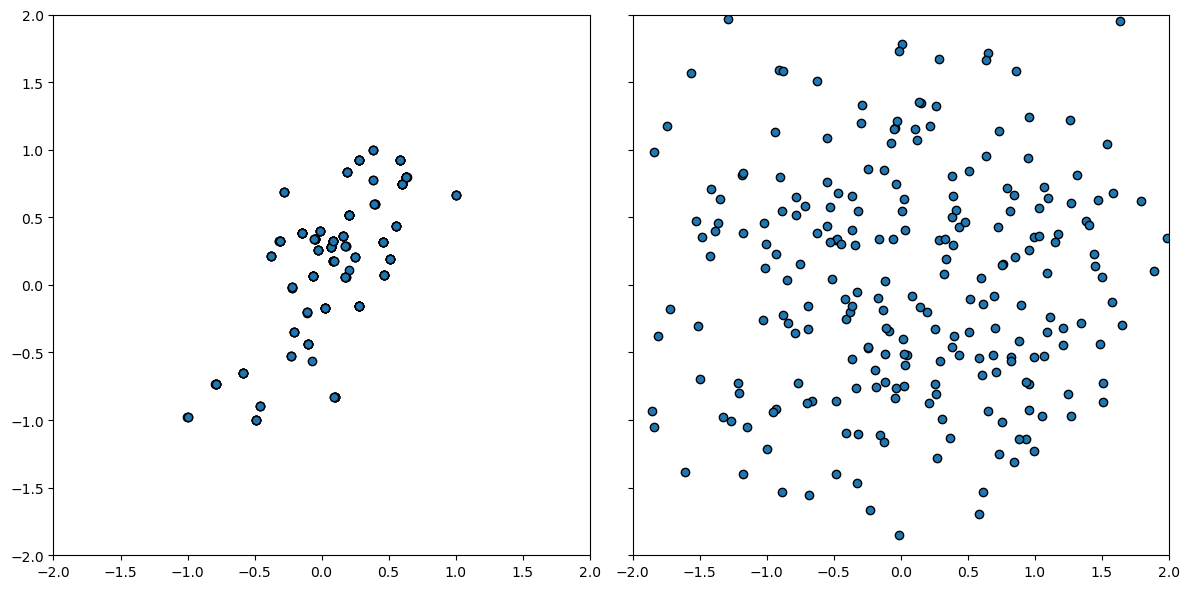

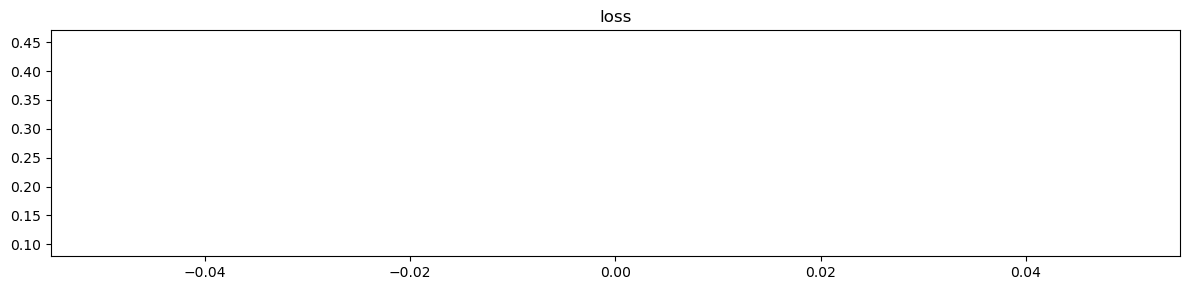

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 12.83it/s]


In [40]:
train_obs_normalization(Obs_Normal_Flow_s0,opt_obs,train_data,var_np*scale,test_data,label=False,epochs=1001)

In [19]:
#save flow
filename = './net/Obs_normal_0_real.pth'
torch.save(Obs_Normal_Flow_s0.state_dict(),filename)

In [16]:
#reload flow
filename = './net/Obs_normal_0_real.pth'
Obs_Normal_Flow_s0 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s0.load_state_dict(state)
Obs_Normal_Flow_s0.eval();

### the encoder-decoder flow of Earth model $f_m^0$

In [44]:
Mod_Normal_Flow_s0 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s0.parameters(),lr=5e-4, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

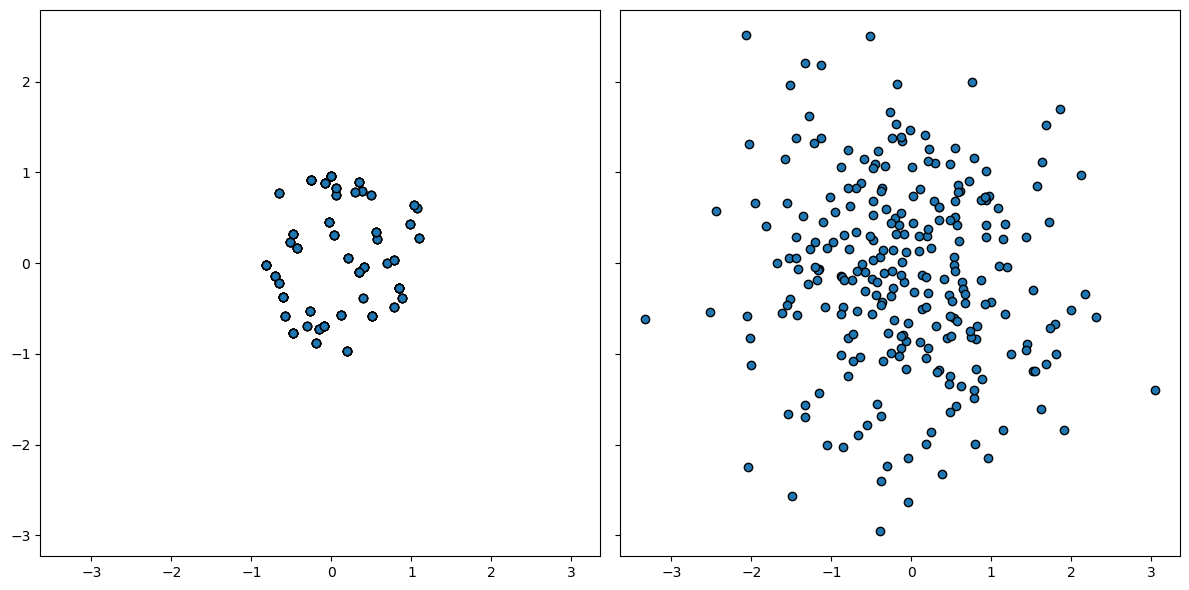

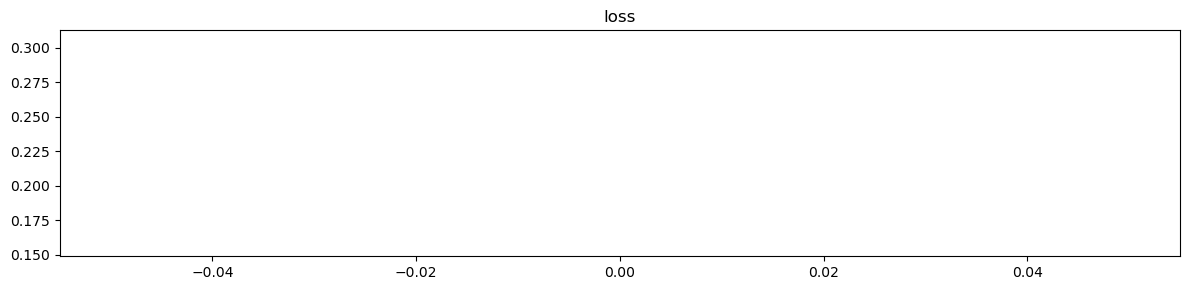

100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 17.01it/s]


In [42]:
train_mod_normalization(Mod_Normal_Flow_s0,opt_mod,train_data,var_np,test_data,label=False,epochs=2001)

In [25]:
#save flow
filename = './net/Mod_normal_0_real.pth'
torch.save(Mod_Normal_Flow_s0.state_dict(),filename)

In [19]:
#reload flow
filename = './net/Mod_normal_0_real.pth'
Mod_Normal_Flow_s0 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s0.load_state_dict(state)
Mod_Normal_Flow_s0.eval();

### The main flow $f^0$

In [45]:
Inverse_flow0 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow0.parameters(), lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)
#opt_inv = torch.optim.Adam(Inverse_flow0.parameters(), lr=5e-3)

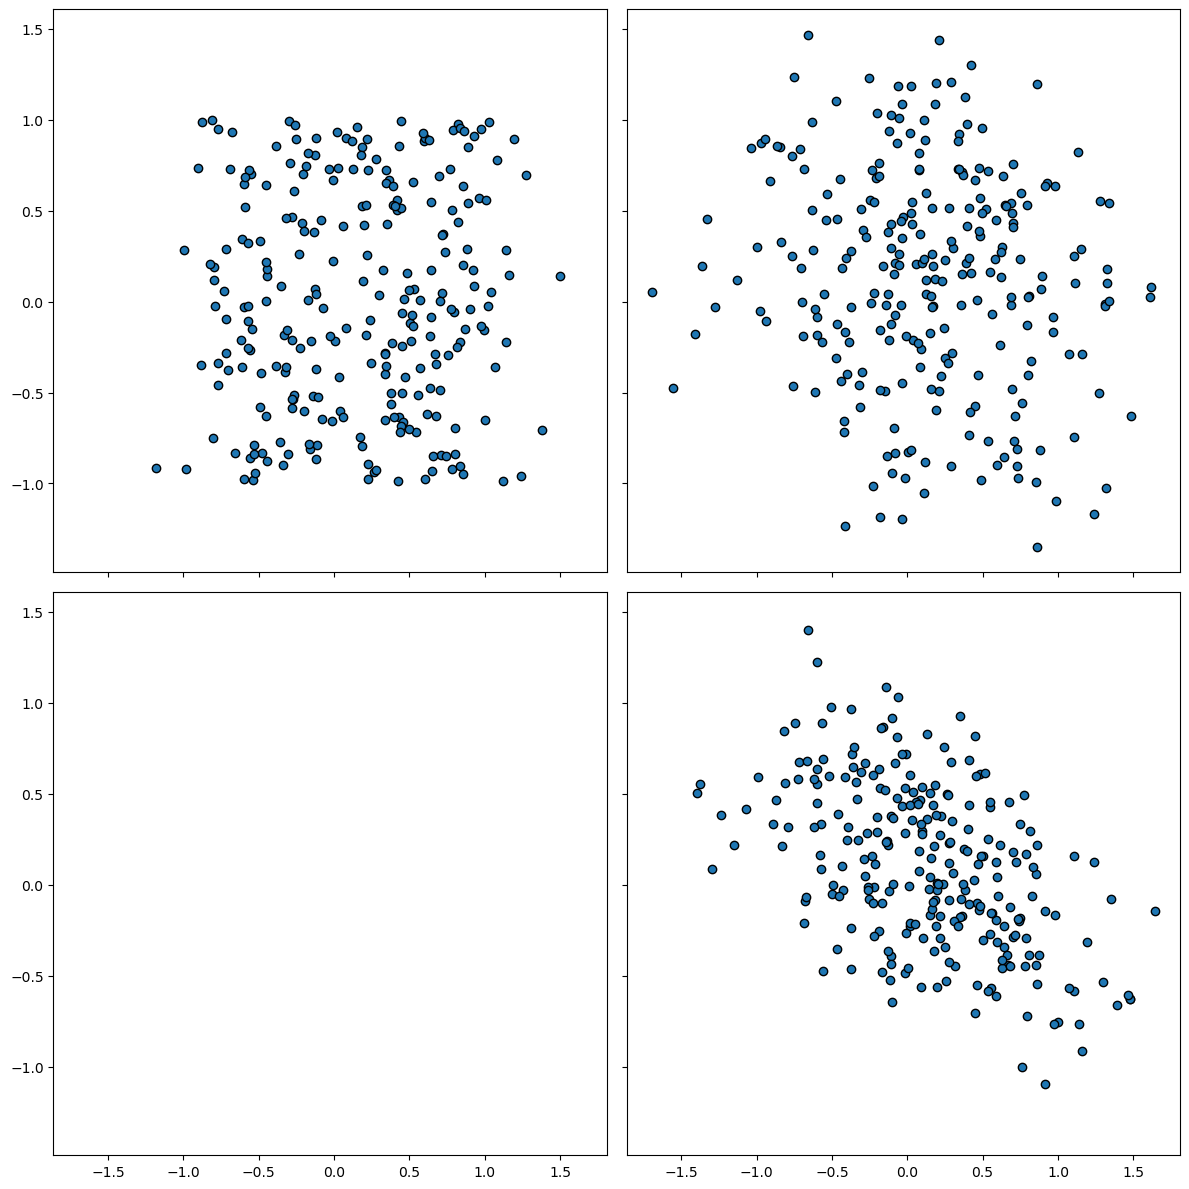

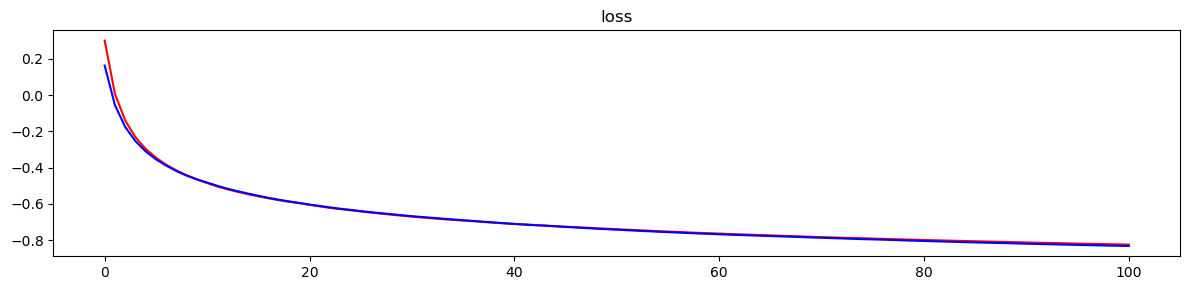

100%|█████████████████████████████████████| 10001/10001 [07:38<00:00, 21.82it/s]


In [29]:
scale = 1.0
#train_inverse_flow_original1(Obs_Normal_Flow_s0,Inverse_flow0,opt_inv,train_data,var_np*scale,obs_tensor,test_data,label=False,epochs=20001)
train_inverse_flow_original(Inverse_flow0,opt_inv,train_data,var_np*scale,obs_tensor,test_data,epochs=10001)

In [30]:
#save flow
filename = './net/Inverse_flow_s0_real.pth'
torch.save(Inverse_flow0.state_dict(),filename)

In [20]:
#reload flow
filename = './net/Inverse_flow_s0_real.pth'
Inverse_flow0 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow0.load_state_dict(state)
Inverse_flow0.eval();

### Check the prediction accuracy.

In [32]:
scale =1.0
SAMPLE_SIZE = 500
ert_mean = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
ert_max = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np*scale,2))).
                                                                    type(torch.float32))
for i in range(SAMPLE_SIZE):
    obs_test = torch.tensor(obs_normal[i],device=device,dtype=torch.float32)
    obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    error = err_dist.sample((BATCH_SIZE,)).cuda()
    rand_ert = torch.randn(BATCH_SIZE,OUTPUT_SIZE,device=device) 
    ert_fake,jac = Inverse_flow0(rand_ert,obs_tensor,rev=True,jac=False)
    ert_fake = ert_fake.detach().cpu().numpy()
    ert_mean[i] = ert_fake.mean(axis=0)

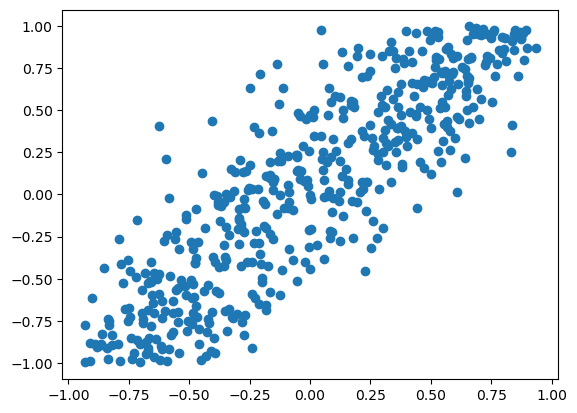

In [37]:
N1= model_pair['Lm1_vsv']
plt.scatter(ert_mean[:500,N1],model_syn[:500,N1])

### Determine $\alpha$

In [46]:
# Conduct small-batch predictions and adjust the alpha value to ensure that the observed values fall within the predicted range.
Inverse_flow0.eval();
alpha = 0.5
Sample_Size = 5
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np*scale,2))).
                                                                    type(torch.float32))
error = err_dist.sample((Sample_Size,)).cuda()
obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
obs_test = torch.tensor((obs_real-obs_min)/obs_inter*2.-1.,device=device,dtype=torch.float32)
obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
#obs_sample_code = Obs_Normal_Flow_s0(obs_sample_tensor)[0].detach()
rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
ert_fake = Inverse_flow0(rand_ert,obs_sample_tensor,rev=True,jac=False)[0].detach().cpu()
ert_fake = ert_fake.numpy()
ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*alpha
ert_fake = ert_fake+ert_err
file_name = './data/Inverse_sample_step0_1_test.txt'
np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
chmod u+x ./maker_folder_test.sh
./maker_folder_test.sh 0
```

In [48]:
Sample_test(step=0,doc_num=1,Sample_N=5)

### Execute the shell code to generate observation samples
```bash
cd ./Mineos/DEMO/Earth
chmod u+x ./RUN_MIEOS_test.sh
./RUN_MIEOS_test.sh 0 1
```

In [49]:
Read_file_test(step=0,doc_num=1,model_num=5)

In [50]:
obs_min0_test = np.loadtxt('./data/new_obs_min_0_test.txt')
obs_inter0_test = np.loadtxt('./data/new_obs_inter_0_test.txt')
model_syn0_test = np.loadtxt('./data/new_model_syn_0_test.txt')
obs_normal0_test = np.loadtxt('./data/new_obs_normal_0_test.txt')

In [51]:
obs_test = (obs_normal0_test+1.)/2.*obs_inter0_test+obs_min0_test
diff0_test = (obs_test-obs_real)/obs_std

In [52]:
# if the results are both [], the alpha is acceptable
np.where(diff0_test.mean(axis=0)+1*diff0_test.std(axis=0) < 0),np.where(diff0_test.mean(axis=0)-1*diff0_test.std(axis=0) > 0)

((array([ 30,  31,  32,  49,  59,  65,  66,  67,  69,  70,  71,  86,  89,
          97,  98,  99, 100, 103, 104, 105, 111, 112, 124, 125, 126, 127,
         130, 131, 136, 141, 142, 146, 147, 148, 149, 150, 151, 152]),),
 (array([], dtype=int64),))

### Generate the prior model for the next step.

In [46]:
alpha = 0.5
Inverse_flow0.eval();
file_num = 10
for num in range(1,file_num+1):
    Sample_Size = 10000
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min)/obs_inter*2.-1.,device=device,dtype=torch.float32)
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    #obs_sample_code = Obs_Normal_Flow_s0(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake = Inverse_flow0(rand_ert,obs_sample_tensor,rev=True,jac=False)[0].detach().cpu()
    ert_fake = ert_fake.numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*alpha
    ert_fake = ert_fake+ert_err
    file_name = './data/Inverse_sample_step1_{0}.txt'.format(num)
    np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
./maker_folder_test.sh 1
```

In [47]:
Sample(step=1,doc_num=10)

### Execute the shell code to generate observation samples
```bash
./RUN_MIEOS.sh 1 1
./RUN_MIEOS.sh 1 2
...
./RUN_MIEOS.sh 1 10
```

In [59]:
Read_file(step=1,doc_num=10)

================================================
# Iterative Step 1

In [21]:
obs_min1 = np.loadtxt('./data/new_obs_min_1.txt')
obs_inter1 = np.loadtxt('./data/new_obs_inter_1.txt')
model_syn1 = np.loadtxt('./data/new_model_syn_1.txt')
obs_normal1 = np.loadtxt('./data/new_obs_normal_1.txt')

In [27]:
#Calculate the special weighting factor w
N = int(model_syn1.shape[0]/BATCH_SIZE)+1
weight1 = np.zeros(model_syn1.shape[0])
for i in range(N):
    if i == N:
        mod_tensor = torch.tensor(model_syn1[(N-1)*BATCH_SIZE:],dtype=torch.float32,device=device)
    else:
        mod_tensor = torch.tensor(model_syn1[i*BATCH_SIZE:(i+1)*BATCH_SIZE],dtype=torch.float32,device=device)
    
    z,log_jac_det = Mod_Normal_Flow_s0(mod_tensor)
    loss0 = (0.5*torch.sum(z**2,1) - log_jac_det)/OUTPUT_SIZE
    
    obs_test = obs_tensor[:mod_tensor.shape[0]]
    z,log_jac_det = Inverse_flow0(mod_tensor,obs_test)
    loss1 = (0.5*torch.sum(z**2,1) - log_jac_det)/OUTPUT_SIZE
    
    if i == N:
        weight1[(N-1)*BATCH_SIZE:] = (loss1-loss0).detach().cpu().numpy()
    else:
        weight1[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = (loss1-loss0).detach().cpu().numpy()

weight1 = weight1-weight1.mean()
weight1 = np.exp(weight1)

In [28]:
TOTAL_SAMPLE = obs_normal1.shape[0]
TRAIN_SIZE = int(0.95*TOTAL_SAMPLE)
TEST_SIZE = TOTAL_SAMPLE - TRAIN_SIZE

x_train1 = torch.tensor(obs_normal1[:TRAIN_SIZE],dtype=torch.float32)
x_test1 = torch.tensor(obs_normal1[-TEST_SIZE:],dtype=torch.float32)
y_train1 = torch.tensor(model_syn1[:TRAIN_SIZE],dtype=torch.float32)
y_test1 = torch.tensor(model_syn1[-TEST_SIZE:],dtype=torch.float32)
w_train1 = torch.tensor(weight1[:TRAIN_SIZE],dtype=torch.float32)
w_test1 = torch.tensor(weight1[-TEST_SIZE:],dtype=torch.float32)

Obs_Size = INPUT_SIZE
Model_Size = OUTPUT_SIZE

var_np1 = obs_std/obs_inter1*2.
var1 = torch.tensor(obs_std/obs_inter1*2.,dtype=torch.float32)
obs_test1 = torch.tensor((obs_real-obs_min1)/obs_inter1*2.-1.,device=device,dtype=torch.float32)
obs_tensor1 = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
obs_tensor1[:] = obs_test1.reshape(1,INPUT_SIZE)

train_data1 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train1,y_train1,w_train1),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data1 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test1,y_test1,w_test1),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### encoder-decoder of observations $f_d^1$

In [76]:
scale = 4.0
Obs_Normal_Flow_s1 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s1.parameters(), lr=1e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)
#opt_obs = torch.optim.Adam(Obs_Normal_Flow_s1.parameters(), lr=5e-3)

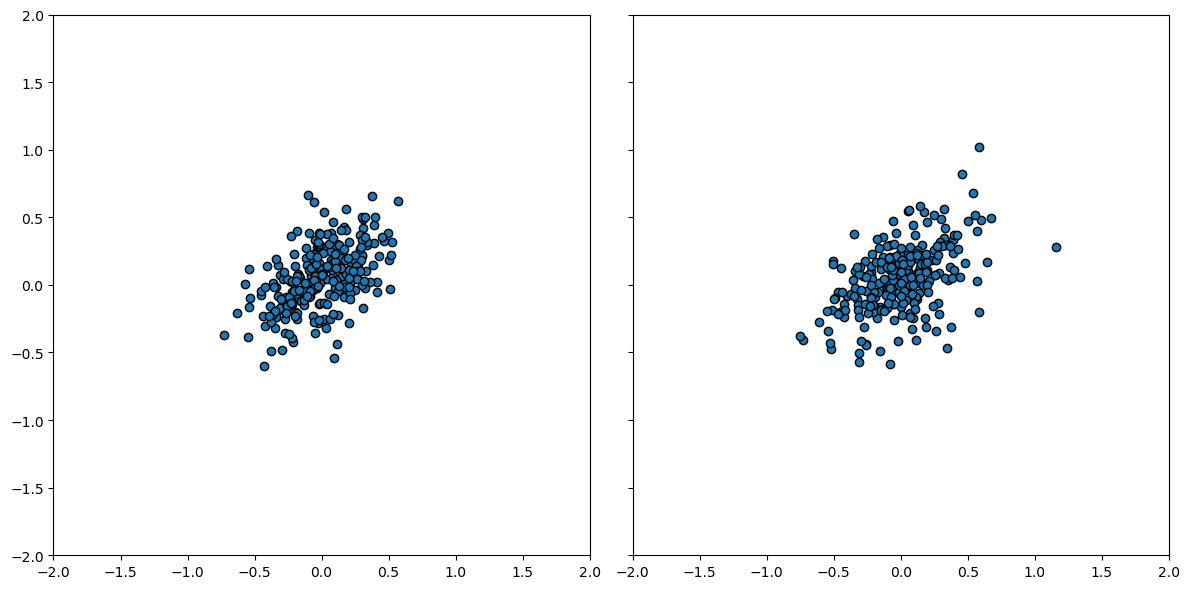

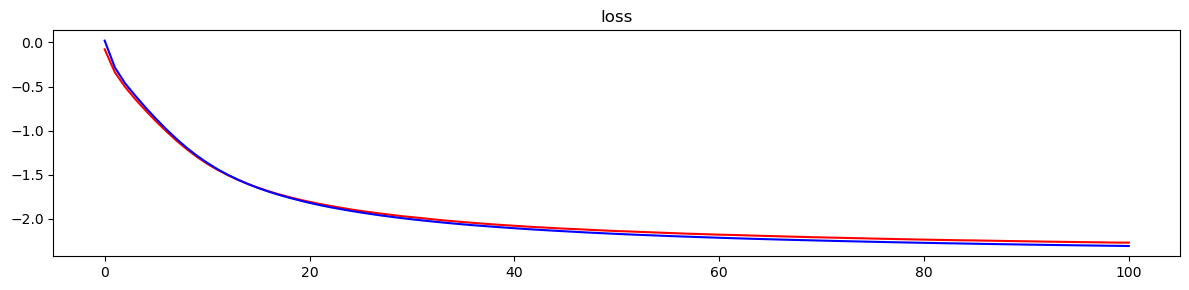

100%|█████████████████████████████████████| 10001/10001 [07:05<00:00, 23.49it/s]


In [77]:
train_obs_normalization(Obs_Normal_Flow_s1,opt_obs,train_data1,var_np1*scale,test_data1,label=True,epochs=10001)

In [78]:
#save flow
filename = './net/Obs_normal_1_real.pth'
torch.save(Obs_Normal_Flow_s1.state_dict(),filename)

In [29]:
#reload flow
filename = './net/Obs_normal_1_real.pth'
Obs_Normal_Flow_s1 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s1.load_state_dict(state)
Obs_Normal_Flow_s1.eval();

## encoder-decoder of Earth model $f_m^1$

In [82]:
Mod_Normal_Flow_s1 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s1.parameters(),lr=5e-4, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

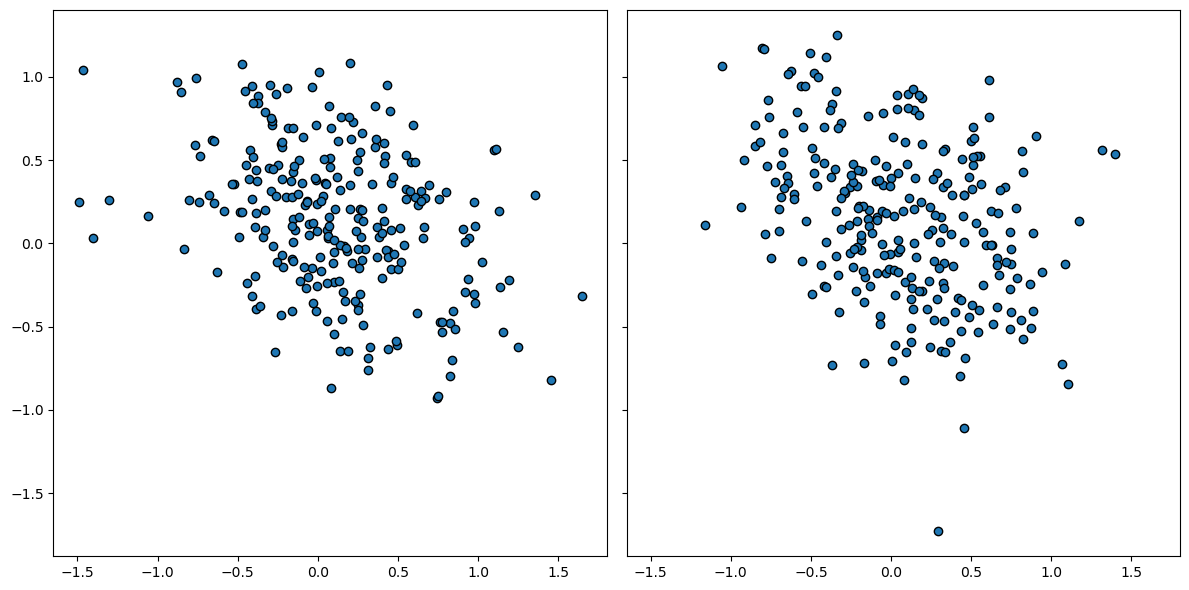

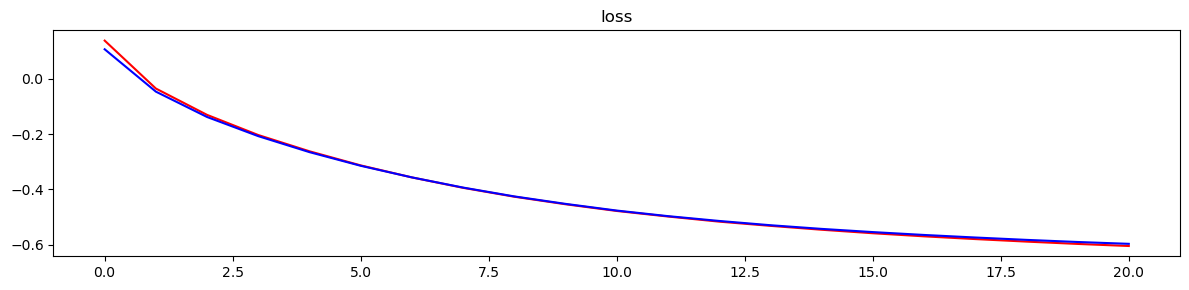

100%|███████████████████████████████████████| 2001/2001 [01:29<00:00, 22.42it/s]


In [83]:
train_mod_normalization(Mod_Normal_Flow_s1,opt_mod,train_data1,var_np1*scale,test_data1,label=True,epochs=2001)

In [84]:
#save flow
filename = './net/Mod_normal_1_real.pth'
torch.save(Mod_Normal_Flow_s1.state_dict(),filename)

In [30]:
#reload flow
filename = './net/Mod_normal_1_real.pth'
Mod_Normal_Flow_s1 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s1.load_state_dict(state)
Mod_Normal_Flow_s1.eval();

### The main flow $f^1$

In [86]:
Inverse_flow_s1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s1.parameters(), lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)
#opt_inv = torch.optim.Adam(Inverse_flow0.parameters(), lr=5e-3)

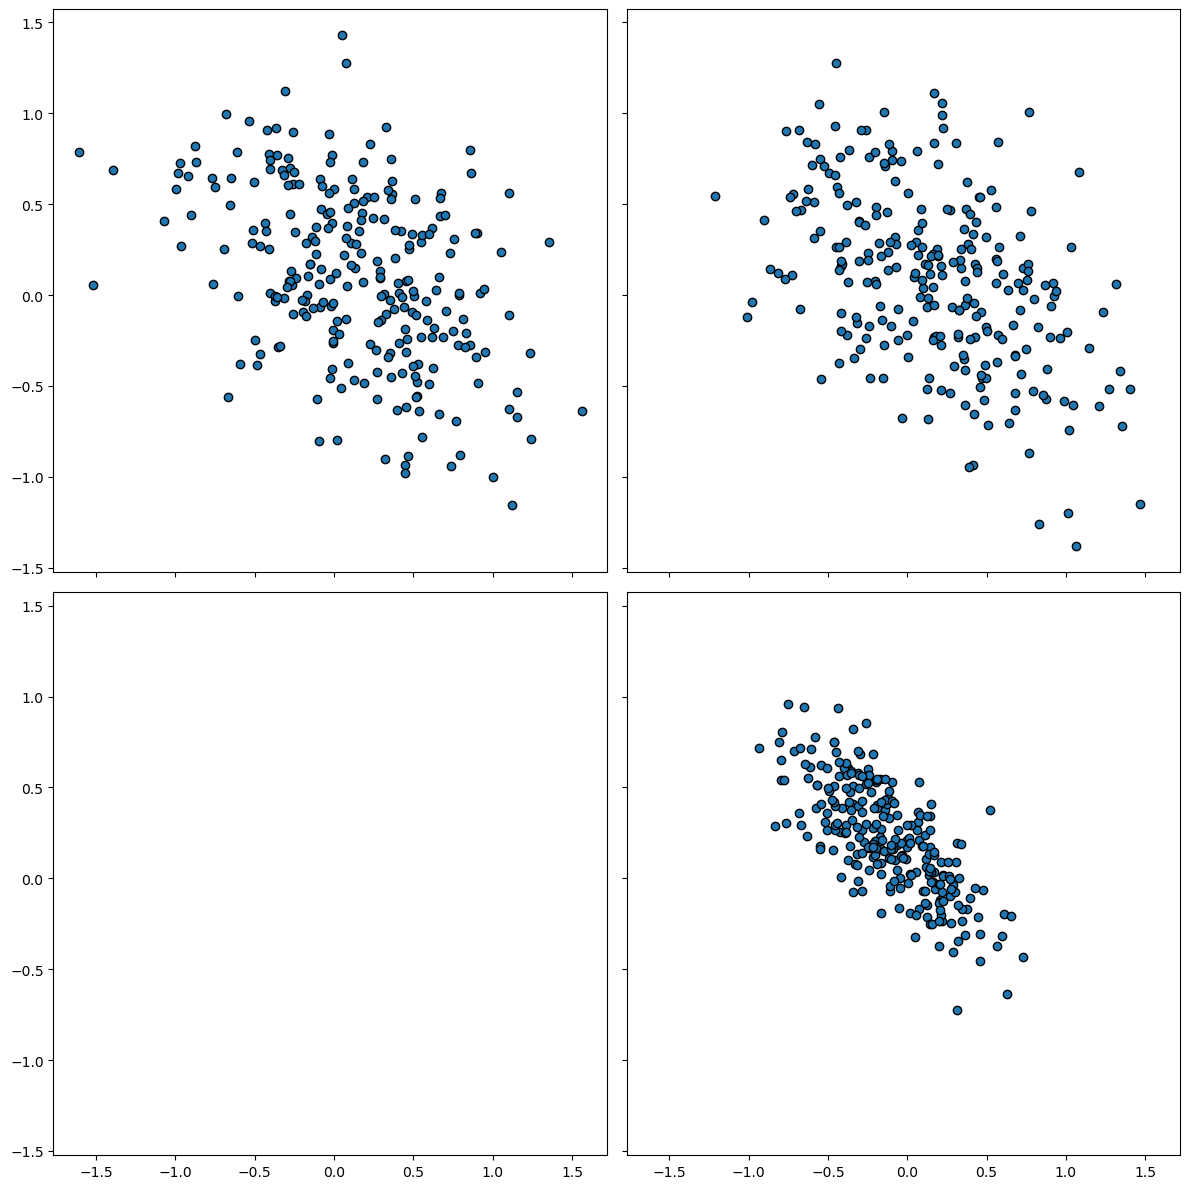

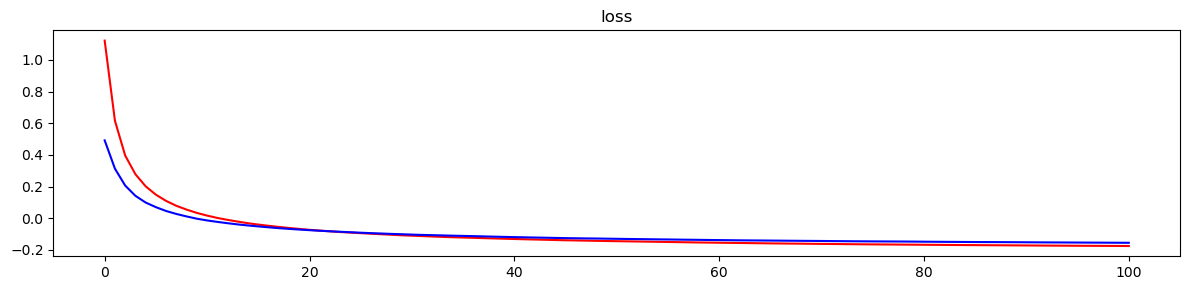

100%|█████████████████████████████████████| 10001/10001 [11:30<00:00, 14.48it/s]


In [87]:
scale = 4.0
train_inverse_flow(Obs_Normal_Flow_s1,Mod_Normal_Flow_s1,Inverse_flow_s1,opt_inv,train_data1,var_np1*scale,obs_tensor1,test_data1,label=True,epochs=10001)
#train_inverse_flow_original(Inverse_flow_s1,opt_inv,train_data1,var_np1*scale,obs_tensor1,test_data1,label=True,epochs=10001)

In [88]:
#save flow
filename = './net/Inverse_flow_s1_real.pth'
torch.save(Inverse_flow_s1.state_dict(),filename)

In [31]:
#reload flow
filename = './net/Inverse_flow_s1_real.pth'
Inverse_flow_s1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s1.load_state_dict(state)
Inverse_flow_s1.eval();

### Determine $\alpha$

In [32]:
# Conduct small-batch predictions and adjust the alpha value to ensure that the observed values fall within the predicted range.
alpha = 0.02
scale = 4.
Inverse_flow_s1.eval();
file_num = 1
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np1*scale,2))).
                                                                    type(torch.float32))

for num in range(1,file_num+1):
    Sample_Size = 300
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min1)/obs_inter1*2.-1.,device=device,dtype=torch.float32)
    #obs_test = torch.tensor(obs_real_test,device=device,dtype=torch.float32)
    #error = err_dist.sample((Sample_Size,)).cuda()
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    obs_sample_code = Obs_Normal_Flow_s1(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake_code = Inverse_flow_s1(rand_ert,obs_sample_code,rev=True,jac=False)[0]
    #ert_fake = ert_fake.cpu().detach().numpy()
    ert_fake = Mod_Normal_Flow_s1(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*alpha
    ert_fake = ert_fake+ert_err
    #ert_fake = ert_fake_code.detach().cpu().numpy()
    file_name = './data/Inverse_sample_step1_{0}_test.txt'.format(num)
    np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
./maker_folder_test.sh 1
```

In [91]:
Sample_test(step=1,Sample_N=300)

### Execute the shell code to generate observation samples
```bash
cd ./Mineos/DEMO/Earth
./RUN_MIEOS_test.sh 1 1
```

In [92]:
Read_file_test(step=1,model_num=300)

In [93]:
obs_min1_test = np.loadtxt('./data/new_obs_min_1_test.txt')
obs_inter1_test = np.loadtxt('./data/new_obs_inter_1_test.txt')
model_syn1_test = np.loadtxt('./data/new_model_syn_1_test.txt')
obs_normal1_test = np.loadtxt('./data/new_obs_normal_1_test.txt')

In [94]:
obs_test = (obs_normal1_test+1.)/2.*obs_inter1_test+obs_min1_test
diff1_test = (obs_test-obs_real)/obs_std

In [97]:
np.where(diff1_test.mean(axis=0)+1.1*diff1_test.std(axis=0) < 0),np.where(diff1_test.mean(axis=0)-1.*diff1_test.std(axis=0) > 0)

((array([], dtype=int64),), (array([], dtype=int64),))

### Check the prediction accuracy.

In [160]:
SAMPLE_SIZE = 500
Inverse_flow_s1.eval();
ert_mean = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
ert_max = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np1*scale,2))).
                                                                    type(torch.float32))
for i in range(SAMPLE_SIZE):
    obs_test = torch.tensor(obs_normal1[i],device=device,dtype=torch.float32)
    obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    error = err_dist.sample((BATCH_SIZE,)).cuda()
    obs_sample_code = Obs_Normal_Flow_s1(obs_tensor+error)[0].detach() 
    rand_ert = torch.randn(BATCH_SIZE,OUTPUT_SIZE,device=device) 
    ert_fake_code,jac = Inverse_flow_s1(rand_ert,obs_sample_code,rev=True,jac=False)
    #ert_fake = ert_fake.detach().cpu().numpy()
    #ert_fake,jac = Inverse_flow0(rand_ert,obs_sample_code,rev=True,jac=False)
    ert_fake = Mod_Normal_Flow_s1(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    
    #ert_fake = ert_fake_code.detach().cpu().numpy()
    #logp = 0.5*torch.sum(rand_ert**2,1)+jac
    #ert_fake = ert_fake.detach().cpu().numpy()
    #ert_max[i] = ert_fake[logp.argmax().item()]
    #ert_fake = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    ert_mean[i] = ert_fake.mean(axis=0)

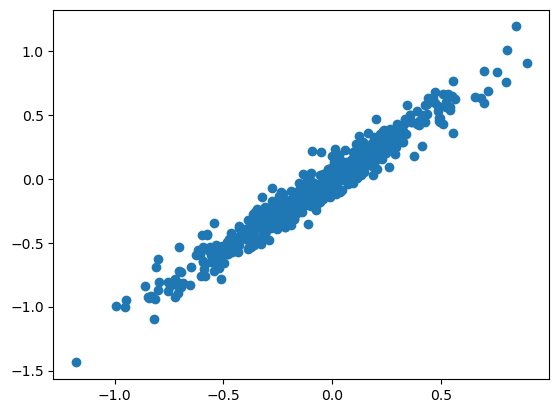

In [169]:
N = N2
plt.scatter(ert_mean[:500,N],model_syn1[:500,N])

### Generate the prior model samples for the next step.

In [99]:
Inverse_flow_s1.eval();
file_num = 10
for num in range(1,file_num+1):
    Sample_Size = 10000
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min1)/obs_inter1*2.-1.,device=device,dtype=torch.float32)
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    obs_sample_code = Obs_Normal_Flow_s1(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake_code = Inverse_flow_s1(rand_ert,obs_sample_code,rev=True,jac=False)[0]
    ert_fake = Mod_Normal_Flow_s1(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*0.02
    ert_fake = ert_fake+ert_err
    
    file_name = './data/Inverse_sample_step2_{0}.txt'.format(num)
    np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
./maker_folder_test.sh 2
```

In [100]:
Sample(step=2,doc_num=10)

### Execute the shell code to generate observation samples
```bash
./RUN_MIEOS.sh 2 1
./RUN_MIEOS.sh 2 2
...
./RUN_MIEOS.sh 2 10
```

In [101]:
Read_file(step=2,doc_num=10)

=========================================
# Inerative Step 2

In [33]:
obs_min2 = np.loadtxt('./data/new_obs_min_2.txt')
obs_inter2 = np.loadtxt('./data/new_obs_inter_2.txt')
model_syn2 = np.loadtxt('./data/new_model_syn_2.txt')
obs_normal2 = np.loadtxt('./data/new_obs_normal_2.txt')

In [39]:
N = int(model_syn2.shape[0]/BATCH_SIZE)+1
weight2 = np.zeros(model_syn2.shape[0])
for i in range(N):
    if i == N:
        mod_tensor = torch.tensor(model_syn2[(N-1)*BATCH_SIZE:],dtype=torch.float32,device=device)
    else:
        mod_tensor = torch.tensor(model_syn2[i*BATCH_SIZE:(i+1)*BATCH_SIZE],dtype=torch.float32,device=device)
    
    z,log_jac_det = Mod_Normal_Flow_s0(mod_tensor)
    loss0 = (0.5*torch.sum(z**2,1) - log_jac_det)/OUTPUT_SIZE
    
    obs_test2 = obs_tensor1[:mod_tensor.shape[0]]
    obs_code2 = Obs_Normal_Flow_s1(obs_test2)[0].detach()
    mod_code2 = Mod_Normal_Flow_s1(mod_tensor)[0].detach()
    
    z,log_jac_det = Inverse_flow_s1(mod_code2,obs_code2)
    loss1 = (0.5*torch.sum(z**2,1) - log_jac_det)/OUTPUT_SIZE
    
    if i == N:
        weight2[(N-1)*BATCH_SIZE:] = (loss1-loss0).detach().cpu().numpy()
    else:
        weight2[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = (loss1-loss0).detach().cpu().numpy()

weight2 = weight2-weight2.mean()
weight2 = np.exp(weight2)

In [40]:
var_np2 = obs_std/obs_inter2*2.
var2 = torch.tensor(obs_std/obs_inter2*2.,dtype=torch.float32)
obs_test2 = torch.tensor((obs_real-obs_min2)/obs_inter2*2.-1.,device=device,dtype=torch.float32)
obs_tensor2 = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
obs_tensor2[:] = obs_test2.reshape(1,INPUT_SIZE)

In [41]:
TOTAL_SAMPLE = obs_normal2.shape[0]
TRAIN_SIZE = int(0.95*TOTAL_SAMPLE)
TEST_SIZE = TOTAL_SAMPLE - TRAIN_SIZE

x_train2 = torch.tensor(obs_normal2[:TRAIN_SIZE],dtype=torch.float32)
x_test2 = torch.tensor(obs_normal2[-TEST_SIZE:],dtype=torch.float32)
y_train2 = torch.tensor(model_syn2[:TRAIN_SIZE],dtype=torch.float32)
y_test2 = torch.tensor(model_syn2[-TEST_SIZE:],dtype=torch.float32)
w_train2 = torch.tensor(weight2[:TRAIN_SIZE],dtype=torch.float32)
w_test2 = torch.tensor(weight2[-TEST_SIZE:],dtype=torch.float32)

Obs_Size = INPUT_SIZE
Model_Size = OUTPUT_SIZE

train_data2 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train2,y_train2,w_train2),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data2 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test2,y_test2,w_test2),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### encoder-decoder of observations $f_d^2$

In [42]:
scale = 3.0
Obs_Normal_Flow_s2 = Flow(INPUT_SIZE).cuda()
#opt_obs = torch.optim.Adam(Obs_Normal_Flow_s2.parameters(), lr=5e-3)
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s2.parameters(), lr=1e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

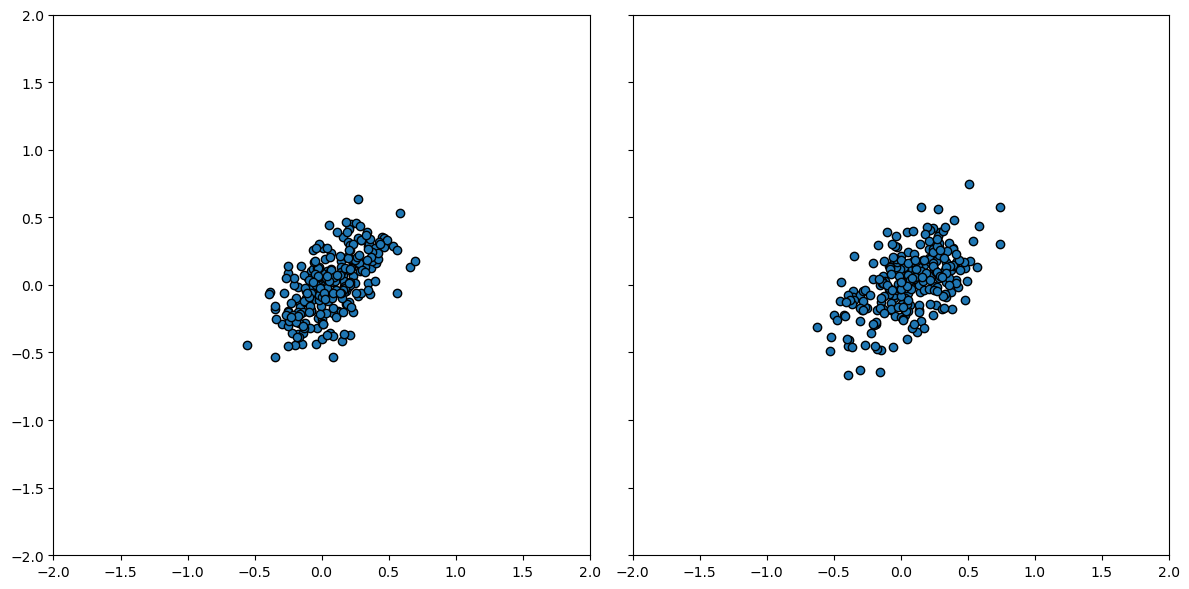

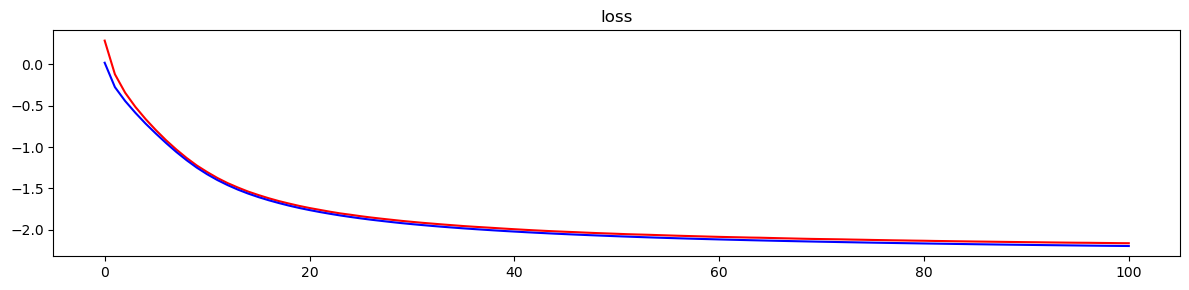

100%|█████████████████████████████████████| 10001/10001 [06:55<00:00, 24.06it/s]


In [43]:
train_obs_normalization(Obs_Normal_Flow_s2,opt_obs,train_data2,var_np2*scale,test_data2,label=True,epochs=10001)

In [44]:
filename = './net/Obs_normal_2_real.pth'
torch.save(Obs_Normal_Flow_s2.state_dict(),filename)

In [42]:
filename = './net/Obs_normal_2_real.pth'
Obs_Normal_Flow_s2 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s2.load_state_dict(state)
Obs_Normal_Flow_s2.eval();

### encoder-decoder of Earth model $f_m^2$

In [70]:
# obstain the normalization flow of observation
Mod_Normal_Flow_s2 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s2.parameters(), lr=5e-3)

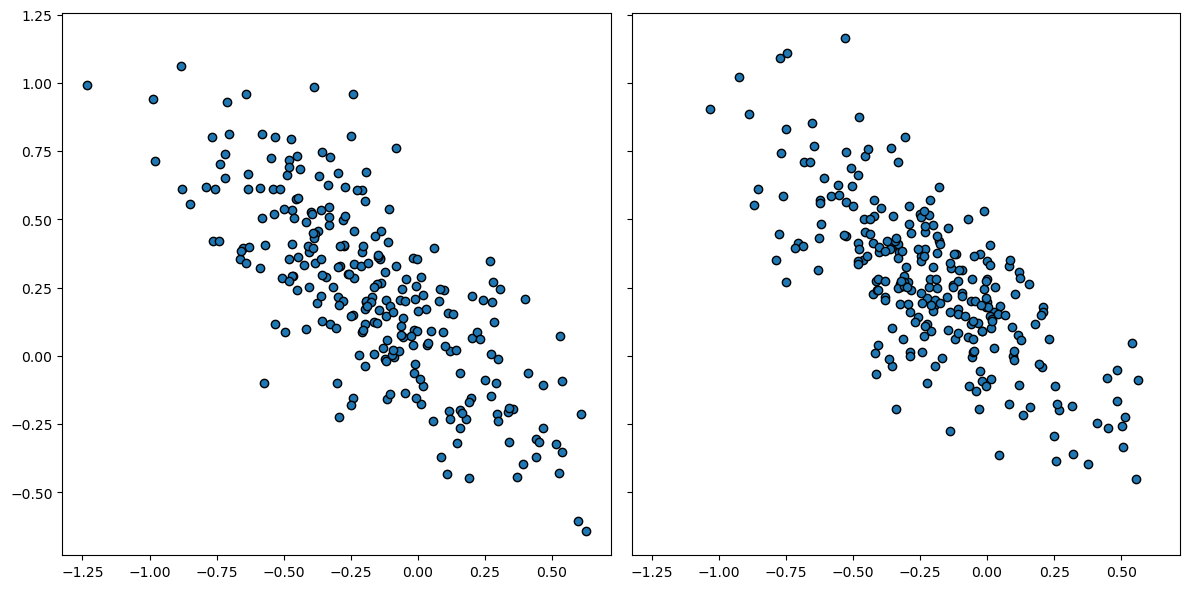

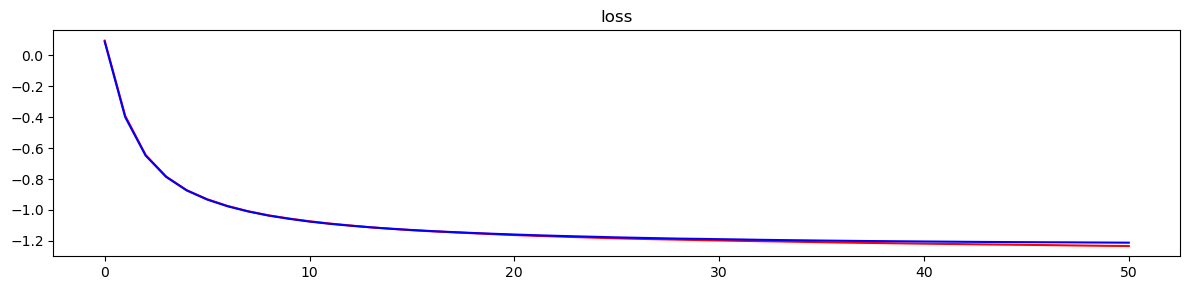

100%|███████████████████████████████████████| 5001/5001 [03:43<00:00, 22.42it/s]


In [71]:
train_mod_normalization(Mod_Normal_Flow_s2,opt_mod,train_data2,var_np2*scale,test_data2,epochs=5001)

In [72]:
filename = './net/Mod_normal_2_real.pth'
torch.save(Mod_Normal_Flow_s2.state_dict(),filename)

In [43]:
filename = './net/Mod_normal_2_real.pth'
Mod_Normal_Flow_s2 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s2.load_state_dict(state)
Mod_Normal_Flow_s2.eval();

### The main flow $f^2$

In [74]:
Inverse_flow_s2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s2.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

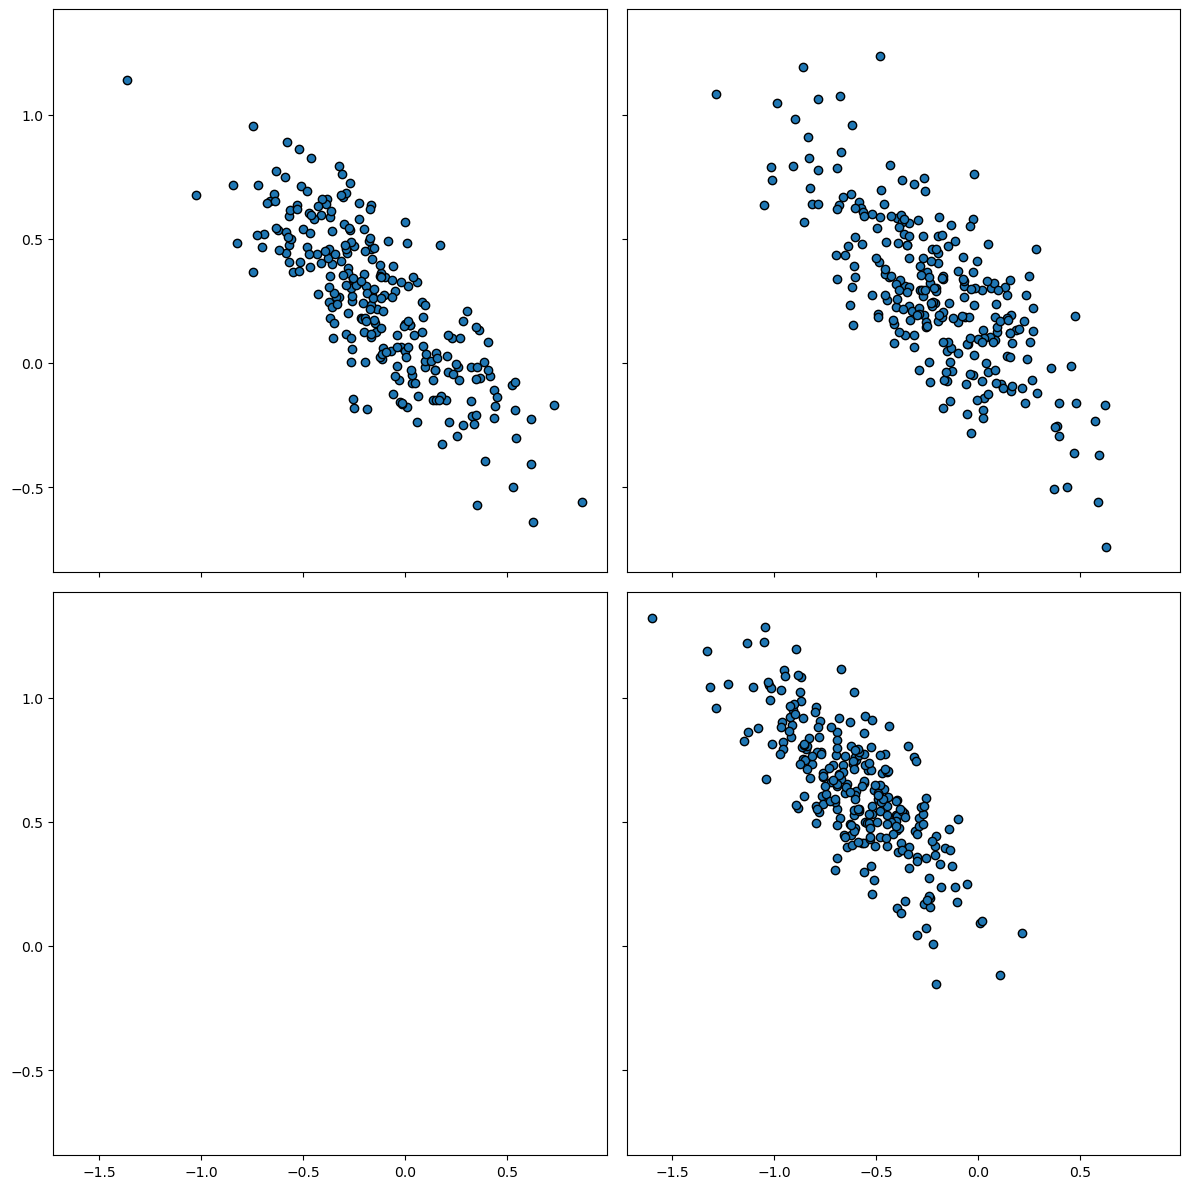

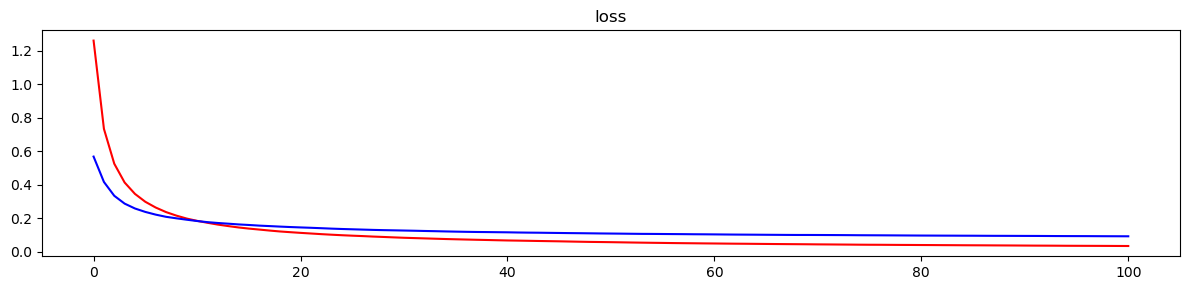

100%|█████████████████████████████████████| 10001/10001 [11:21<00:00, 14.68it/s]


In [75]:
scale = 3.0
train_inverse_flow(Obs_Normal_Flow_s2,Mod_Normal_Flow_s2,Inverse_flow_s2,opt_inv,train_data2,var_np2*scale,obs_tensor2,test_data2,label=True,epochs=10001)

In [76]:
filename = './net/Inverse_flow_s2_real.pth'
torch.save(Inverse_flow_s2.state_dict(),filename)

In [44]:
filename = './net/Inverse_flow_s2_real.pth'
Inverse_flow_s2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s2.load_state_dict(state)
Inverse_flow_s2.eval();

### Determine $\alpha$

In [78]:
Inverse_flow_s2.eval();
file_num = 1
for num in range(1,file_num+1):
    Sample_Size = 300
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min2)/obs_inter2*2.-1.,device=device,dtype=torch.float32)
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    obs_sample_code = Obs_Normal_Flow_s2(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake_code = Inverse_flow_s2(rand_ert,obs_sample_code,rev=True,jac=False)[0].detach()
    ert_fake = Mod_Normal_Flow_s2(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    #ert_fake = ert_fake_code.cpu().numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*0.005
    ert_fake = ert_fake+ert_err
    
    file_name = './data/Inverse_sample_step2_{0}_test.txt'.format(num)
    np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
./maker_folder_test.sh 2
```

In [79]:
Sample_test(step=2,Sample_N=300)

### Execute the shell code to generate observation samples
```bash
cd ./Mineos/DEMO/Earth
./RUN_MIEOS_test.sh 2 1
```

In [80]:
Read_file_test(step=2,doc_num=1,model_num=300)

In [81]:
obs_min2_test = np.loadtxt('./data/new_obs_min_2_test.txt')
obs_inter2_test = np.loadtxt('./data/new_obs_inter_2_test.txt')
model_syn2_test = np.loadtxt('./data/new_model_syn_2_test.txt')
obs_normal2_test = np.loadtxt('./data/new_obs_normal_2_test.txt')

In [82]:
obs_test = (obs_normal2_test+1.)/2.*obs_inter2_test+obs_min2_test
diff2_test = (obs_test-obs_real)/obs_std

In [84]:
np.where(diff2_test.mean(axis=0)+1.5*diff2_test.std(axis=0) < 0),np.where(diff2_test.mean(axis=0)-1.5*diff2_test.std(axis=0) > 0)

((array([159]),), (array([], dtype=int64),))

### Generate the prior model for the next step.

In [86]:
Inverse_flow_s2.eval();
file_num = 10
for num in range(1,file_num+1):
    Sample_Size = 10000
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min2)/obs_inter2*2.-1.,device=device,dtype=torch.float32)
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    obs_sample_code = Obs_Normal_Flow_s2(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake_code = Inverse_flow_s2(rand_ert,obs_sample_code,rev=True,jac=False)[0].detach()
    ert_fake = Mod_Normal_Flow_s2(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*0.005
    ert_fake = ert_fake+ert_err
    
    file_name = './data/Inverse_sample_step3_{0}.txt'.format(num)
    np.savetxt(file_name,ert_fake)

### bash
```bash
cd ./Mineos/DEMO/Earth
./maker_folder_test.sh 3
```

In [87]:
Sample(step=3,doc_num=10)

### Execute the shell code to generate observation samples
```bash
./RUN_MIEOS.sh 3 1
./RUN_MIEOS.sh 3 2
...
./RUN_MIEOS.sh 3 10
```

In [88]:
Read_file(step=3,doc_num=10)

=============================================
# Inerative Step 3

In [45]:
obs_min3 = np.loadtxt('./data/new_obs_min_3.txt')
obs_inter3 = np.loadtxt('./data/new_obs_inter_3.txt')
model_syn3 = np.loadtxt('./data/new_model_syn_3.txt')
obs_normal3 = np.loadtxt('./data/new_obs_normal_3.txt')

In [53]:
N = int(model_syn3.shape[0]/BATCH_SIZE)+1
weight3 = np.zeros(model_syn3.shape[0])
for i in range(N):
    if i == N:
        mod_tensor = torch.tensor(model_syn3[(N-1)*BATCH_SIZE:],dtype=torch.float32,device=device)
    else:
        mod_tensor = torch.tensor(model_syn3[i*BATCH_SIZE:(i+1)*BATCH_SIZE],dtype=torch.float32,device=device)
    
    z,log_jac_det = Mod_Normal_Flow_s0(mod_tensor)
    loss0 = (0.5*torch.sum(z**2,1) - log_jac_det)/OUTPUT_SIZE
    
    obs_test3 = obs_tensor2[:mod_tensor.shape[0]]
    obs_code3 = Obs_Normal_Flow_s2(obs_test3)[0].detach()
    mod_code3, log_jac_det0 = Mod_Normal_Flow_s2(mod_tensor)
    
    z,log_jac_det = Inverse_flow_s2(mod_code3,obs_code3)
    loss1 = (0.5*torch.sum(z**2,1) - log_jac_det -log_jac_det0)/OUTPUT_SIZE
    
    if i == N:
        weight3[(N-1)*BATCH_SIZE:] = (loss1-loss0).detach().cpu().numpy()
    else:
        weight3[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = (loss1-loss0).detach().cpu().numpy()

weight3 = weight3-weight3.mean()
weight3 = np.exp(weight3)

In [54]:
var_np3 = obs_std/obs_inter3*2.
var3 = torch.tensor(obs_std/obs_inter3*2.,dtype=torch.float32)
obs_test3 = torch.tensor((obs_real-obs_min3)/obs_inter3*2.-1.,device=device,dtype=torch.float32)
obs_tensor3 = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
obs_tensor3[:] = obs_test3.reshape(1,INPUT_SIZE)

In [55]:
TOTAL_SAMPLE = obs_normal3.shape[0]
TRAIN_SIZE = int(0.95*TOTAL_SAMPLE)
TEST_SIZE = TOTAL_SAMPLE - TRAIN_SIZE

x_train3 = torch.tensor(obs_normal3[:TRAIN_SIZE],dtype=torch.float32)
x_test3 = torch.tensor(obs_normal3[-TEST_SIZE:],dtype=torch.float32)
y_train3 = torch.tensor(model_syn3[:TRAIN_SIZE],dtype=torch.float32)
y_test3 = torch.tensor(model_syn3[-TEST_SIZE:],dtype=torch.float32)
w_train3 = torch.tensor(weight3[:TRAIN_SIZE],dtype=torch.float32)
w_test3 = torch.tensor(weight3[-TEST_SIZE:],dtype=torch.float32)

Obs_Size = INPUT_SIZE
Model_Size = OUTPUT_SIZE

train_data3 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train3,y_train3,w_train3),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data3 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test3,y_test3,w_test3),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### encoder-decoder of observations $f_d^3$

In [83]:
scale = 2.0
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
#opt_obs = torch.optim.Adam(Obs_Normal_Flow_s2.parameters(), lr=5e-3)
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s3.parameters(), lr=1e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

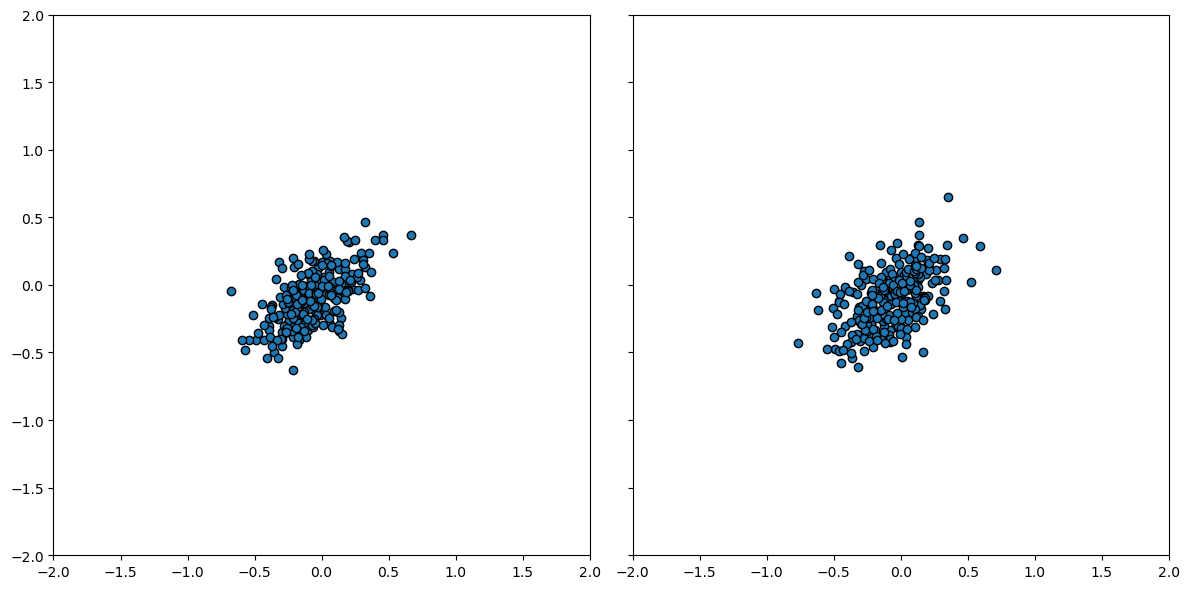

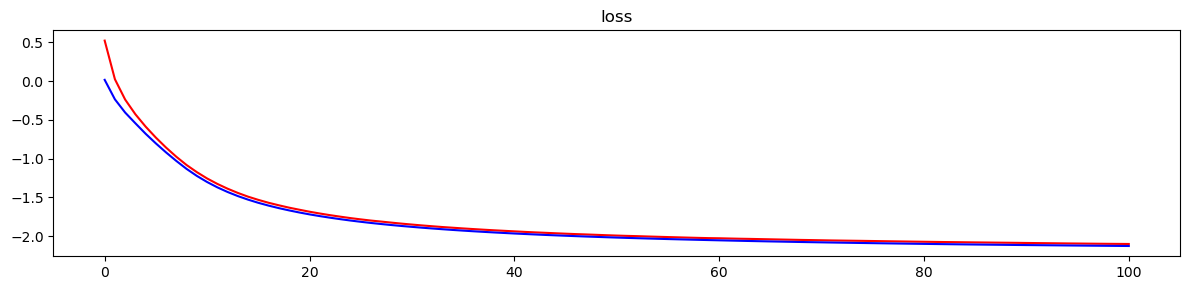

100%|█████████████████████████████████████| 10001/10001 [07:24<00:00, 22.51it/s]


In [84]:
train_obs_normalization(Obs_Normal_Flow_s3,opt_obs,train_data3,var_np3*scale,test_data3,label=True,epochs=10001)

In [87]:
filename = './net/Obs_normal_3_real.pth'
torch.save(Obs_Normal_Flow_s3.state_dict(),filename)

In [88]:
filename = './net/Obs_normal_3_real.pth'
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s3.load_state_dict(state)
Obs_Normal_Flow_s3.eval();

## encoder-decoder of Earth model $f_m^3$

In [61]:
Mod_Normal_Flow_s3 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s3.parameters(), lr=5e-3)

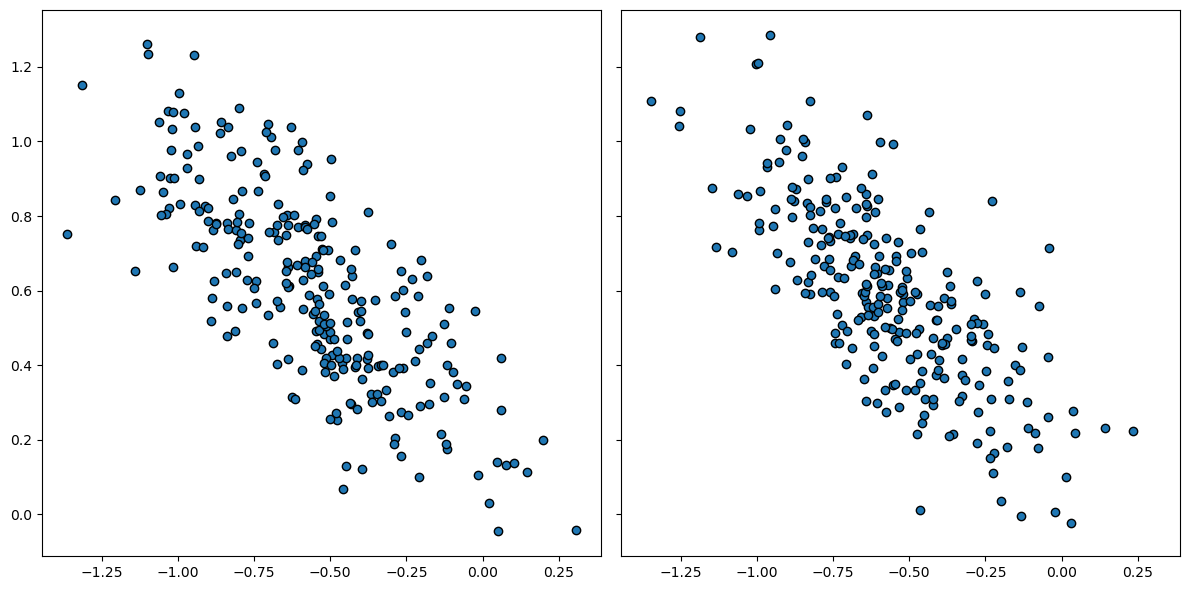

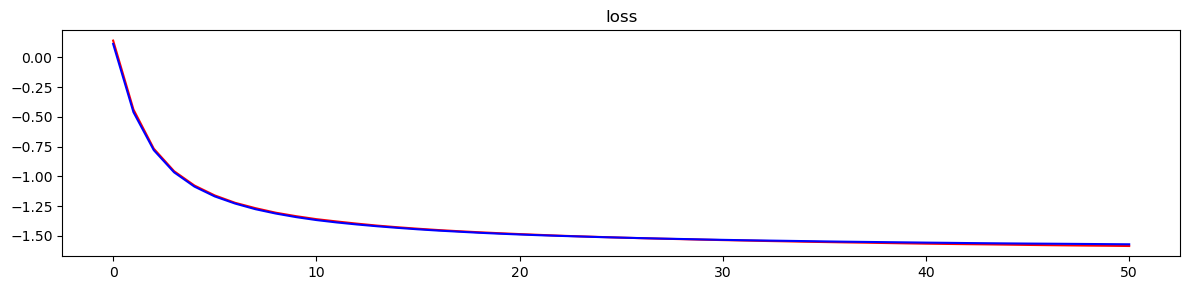

100%|███████████████████████████████████████| 5001/5001 [03:44<00:00, 22.30it/s]


In [62]:
train_mod_normalization(Mod_Normal_Flow_s3,opt_mod,train_data3,var_np3*scale,test_data3,epochs=5001)

In [63]:
filename = './net/Mod_normal_3_real.pth'
torch.save(Mod_Normal_Flow_s3.state_dict(),filename)

In [64]:
filename = './net/Mod_normal_3_real.pth'
Mod_Normal_Flow_s3 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s3.load_state_dict(state)
Mod_Normal_Flow_s3.eval();

In [89]:
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s3.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

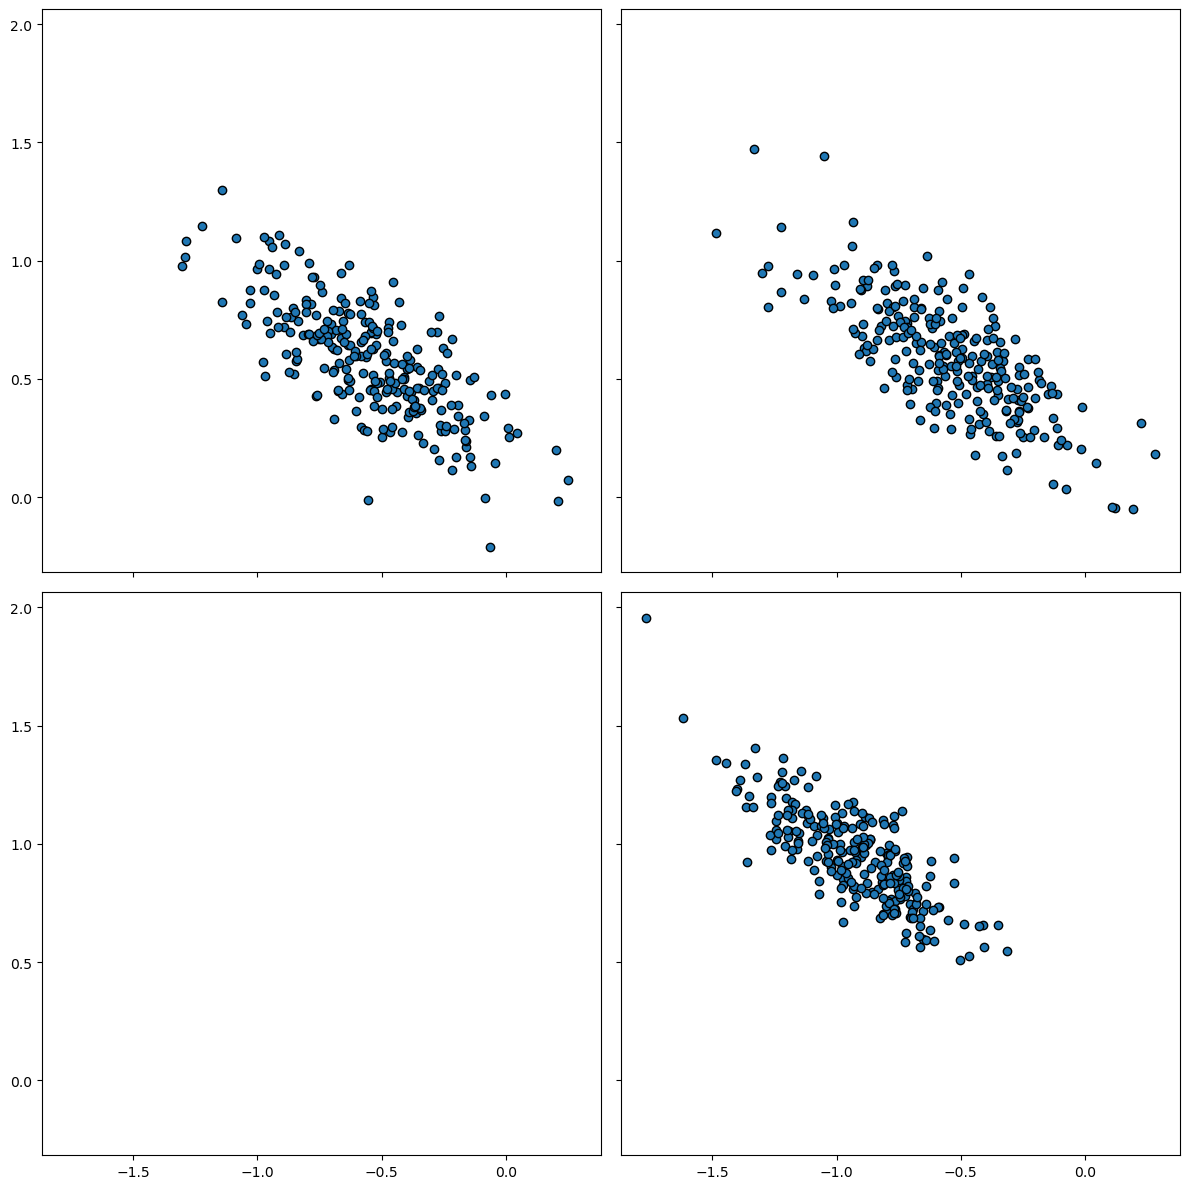

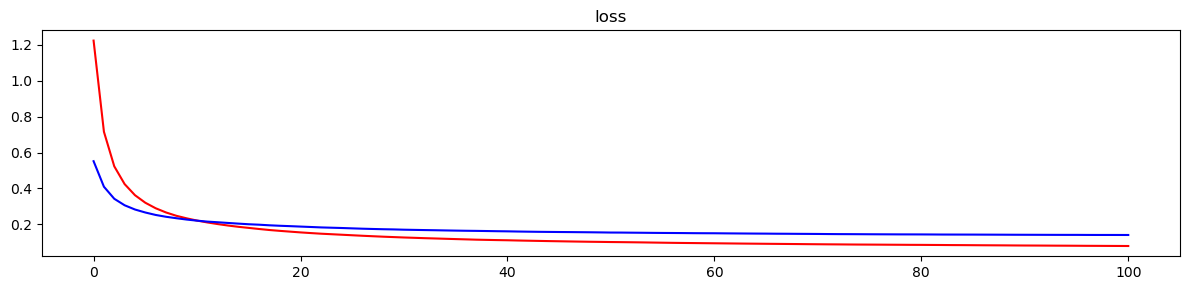

100%|█████████████████████████████████████| 10001/10001 [12:30<00:00, 13.32it/s]


In [90]:
scale = 2.0
train_inverse_flow(Obs_Normal_Flow_s3,Mod_Normal_Flow_s3,Inverse_flow_s3,opt_inv,train_data3,var_np3*scale,obs_tensor3,test_data3,label=True,epochs=10001)

In [91]:
filename = './net/Inverse_flow_s3_real.pth'
torch.save(Inverse_flow_s3.state_dict(),filename)

In [92]:
filename = './net/Inverse_flow_s3_real.pth'
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s3.load_state_dict(state)
Inverse_flow_s3.eval();

### The main flow f^3

In [96]:
Inverse_flow_s3.eval();
file_num = 1
for num in range(1,file_num+1):
    Sample_Size = 300
    obs_sample_tensor = torch.randn(Sample_Size,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_test = torch.tensor((obs_real-obs_min3)/obs_inter3*2.-1.,device=device,dtype=torch.float32)
    obs_sample_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    obs_sample_code = Obs_Normal_Flow_s3(obs_sample_tensor)[0].detach()
    
    rand_ert = torch.randn(Sample_Size,OUTPUT_SIZE,device=device) 
    ert_fake_code = Inverse_flow_s3(rand_ert,obs_sample_code,rev=True,jac=False)[0].detach()
    ert_fake = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    #ert_fake = ert_fake_code.cpu().numpy()
    ert_err = np.random.randn(Sample_Size,OUTPUT_SIZE)*0.
    ert_fake = ert_fake+ert_err
    
    file_name = './data/Inverse_sample_step3_{0}_test.txt'.format(num)
    np.savetxt(file_name,ert_fake)

In [98]:
Sample_test(step=3,Sample_N=300)

In [99]:
Read_file_test(step=3,doc_num=1,model_num=300)

In [100]:
obs_min3_test = np.loadtxt('./data/new_obs_min_3_test.txt')
obs_inter3_test = np.loadtxt('./data/new_obs_inter_3_test.txt')
model_syn3_test = np.loadtxt('./data/new_model_syn_3_test.txt')
obs_normal3_test = np.loadtxt('./data/new_obs_normal_3_test.txt')

In [101]:
obs_normal3_test.shape

(283, 186)

In [102]:
obs_test = (obs_normal3_test+1.)/2.*obs_inter3_test+obs_min3_test
diff3_test = (obs_test-obs_real)/obs_std

In [103]:
np.where(diff3_test.mean(axis=0)+2.*diff3_test.std(axis=0) < 0),np.where(diff3_test.mean(axis=0)-2.*diff3_test.std(axis=0) > 0)

((array([159]),), (array([], dtype=int64),))

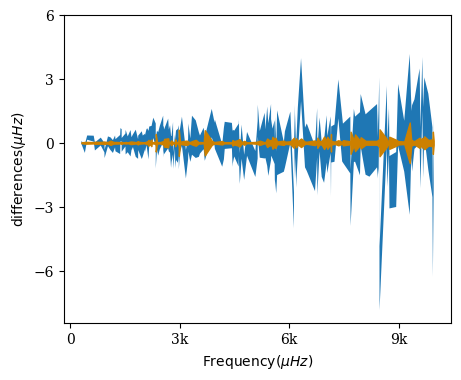

In [130]:
#plt.style.use('_mpl-gallery')
diff_fin = (obs_test-obs_real)
x = obs_real
y1 = diff_fin.std(axis=0)
y2 = diff_fin.mean(axis=0)
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y1_sorted = y1[sort_index]
y2_sorted = y2[sort_index]
obs_std_sorted = obs_std[sort_index]

#fig,ax = plt.subplots(figsize=(3.5,2.5))
fig,ax = plt.subplots(figsize=(5.0,4.0))
ax.fill_between(x_sorted/1000,y2_sorted+y1_sorted,y2_sorted-y1_sorted)
ax.fill_between(x_sorted/1000,obs_std_sorted,-obs_std_sorted,color=(.8,0.5,0.0))
ax.grid(False)
ax.set_ylabel('differences($\mu Hz$)')
ax.set_xlabel('Frequency($\mu Hz$)')
ax.set_xticks([0,3,6,9])
ax.set_xticklabels(['0','3k','6k','9k'])
ax.set_yticks([-6,-3,0,3,6])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
#fig.savefig('std_diff.svg',dpi=300)